In [1]:
# !pip install ydata-profiling
# !pip install ipywidgets
# !pip install seaborn
# !pip install hvplot
# !pip install ipympl
# !pip install plotly
# !pip install jupyter_bokeh
# ! pip install shap
# !pip install dash dash-bootstrap-components

In [2]:
%cd ..

/Users/moustapha.cisse/projects/gomat-markup-optimization


In [3]:
data_path = "data/Quote_and_Order_Data_2025_01_30.csv"

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import hvplot.pandas
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
import shap

hvplot.extension('plotly')
output_notebook()
# %matplotlib widget
%matplotlib ipympl
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
shap.initjs()

Loading BokehJS ...

In [5]:
data = pd.read_csv(
    data_path, 
    delimiter=",", 
    encoding="latin1", 
    # on_bad_lines="warn", 
    on_bad_lines='warn', 
    engine='python'
    )

# Data cleaning

In [6]:
data = data[data["Seller Price"] > 0]

In [7]:
data.groupby("Quote/Order Number").agg({"Quote/Order Status":"first"}).value_counts()

Quote/Order Status                  
Quote Returned                          11244
Order Complete                           3738
Order Cancelled                           538
Order Work In Progress                    107
New Order                                  88
Order Waiting for Pickup or Delivery       22
Planning Delivery                           3
Name: count, dtype: int64

In [8]:
data = data[data["Quote/Order Status"].isin(["Quote Returned", "Order Complete", "Order Waiting for Pickup or Delivery", "Planning Delivery"])]

# Exploration

In [9]:
data.head()

Type Request Purpose qto Quote/Order Number  category_id Plant Category  \
0  Quote     For Install  No        Q0009-16917           11          Trees   
1  Quote     For Install  No        Q0009-16917           10         Shrubs   
2  Quote     For Install  No        Q0009-16917           11          Trees   
3  Quote     For Install  No        Q0009-16917           11          Trees   
4  Quote     For Install  No        Q0009-16917           11          Trees   

   product_id                       Latin Name  \
0         216  Acer X Freemanii 'Autumn Blaze'   
1         373   Amelanchier Canadensis (Shrub)   
2         851              Betula Nigra (Tree)   
3        1122                 Catalpa Speciosa   
4        1122                 Catalpa Speciosa   

                                  Common Name  product_size_id  ...  \
0  'Jeffersred', 'Autumn Blaze' Freeman Maple              270  ...   
1               Canadian Serviceberry (Shrub)              198  ...   
2                          River Birch (Tree)              200  ...   
3                            Northern Catalpa              268  ...   
4                            Northern Catalpa              270  ...   

  Quote/Order Last Publish Year Quote/Order Created Date  \
0                        2022.0           13/12/21 16:09   
1                        2022.0           13/12/21 16:09   
2                        2022.0           13/12/21 16:09   
3                        2022.0           13/12/21 16:09   
4                        2022.0           13/12/21 16:09   

  Quote/Order Created Date Month  Quote/Order Created Date Year  \
0                            Dec                           2021   
1                            Dec                           2021   
2                            Dec                           2021   
3                            Dec                           2021   
4                            Dec                           2021   

   approx_job_date  Delivery Date (orders)  Timeline Timeline_Month  \
0         01/07/22                          01/07/22            Jul   
1         01/07/22                          01/07/22            Jul   
2         01/07/22                          01/07/22            Jul   
3         01/07/22                          01/07/22            Jul   
4         01/07/22                          01/07/22            Jul   

   Timeline_year Delivery_method  
0           2022          Pickup  
1           2022          Pickup  
2           2022          Pickup  
3           2022          Pickup  
4           2022          Pickup  

[5 rows x 40 columns]

In [10]:
data.columns

Index(['Type', 'Request Purpose', 'qto', 'Quote/Order Number', 'category_id',
       'Plant Category', 'product_id', 'Latin Name', 'Common Name',
       'product_size_id', 'Size', 'product_spec_id', 'Specs', 'QTY',
       'Seller Price', 'Buyer Price', 'seller_company_id', 'Supplier Name',
       'buyer_company_id', 'Buyer Name', 'Delivery Address',
       'Delivery Address Region', 'Delivery Address Zip/Postal Code',
       'Buyer Company Region', 'Supplier_Address', 'Supplier Company Region',
       'Supplier_Zip_Postal_Code', 'Quote/Order Status',
       'Quote/Order Last Publish Date', 'Quote/Order Last Publish Month',
       'Quote/Order Last Publish Year', 'Quote/Order Created Date',
       'Quote/Order Created Date Month', 'Quote/Order Created Date Year',
       'approx_job_date', 'Delivery Date (orders)', 'Timeline',
       'Timeline_Month', 'Timeline_year', 'Delivery_method'],
      dtype='object')

In [11]:
TOP_10_REGIONS = [
    "Florida",
    "Texas",
    "New York",
    "Georgia",
    "South Carolina",
    "California",
    "Tennessee",
    "Louisiana",
    "North Carolina",
    "Mississippi",
    "Maryland",
    "New Jersey",
    "Kentucky",
]

In [12]:
CUSTOMER_COLUMN = "Buyer Name"
ORDER_DATE = "Quote/Order Created Date"
ORDER_ID_COLUMN = "Quote/Order Number"
PRODUCT_ID_COLUMN = "product_id"
PLANT_NAME_COLUMN = "Latin Name"
PLANT_CATEGORY_COLUMN = "Plant Category"
QUOTE_STATUS = "Quote/Order Status"
REGION_COLUMN = "Buyer Company Region"
SELLER_TOTAL = "Seller Total"
BUYER_TOTAL = "Buyer Total"
SELLER_PRICE = "Seller Price"
MARKUP_COLUMN = "Markup"

TOTAL_ITEMS_COLUMN = "Total Line Items"

REQUEST_PURPOSE_COLUMN = "Request Purpose"
QTO_COLUMN = "qto"

In [13]:
data = data[data[REGION_COLUMN].isin(TOP_10_REGIONS)]

In [14]:
data[TOTAL_ITEMS_COLUMN] = data["QTY"]
data[SELLER_TOTAL] = data["Seller Price"] * data["QTY"]
data[BUYER_TOTAL] = data["Buyer Price"] * data["QTY"]
data[MARKUP_COLUMN] = (data[BUYER_TOTAL] - data[SELLER_TOTAL])*100 / data[SELLER_TOTAL]
data[ORDER_DATE] = pd.to_datetime(data[ORDER_DATE], dayfirst=True).dt.date
data[QUOTE_STATUS] = data[QUOTE_STATUS].replace(
    {
        "Order Waiting for Pickup or Delivery":1,
        "Order Complete":1,
        "Planning Delivery":1,
        "Quote Returned":0,
    }
)

/var/folders/ds/1rp8l3k557s90rf79xcczzg00000gp/T/ipykernel_45359/3224605159.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[ORDER_DATE] = pd.to_datetime(data[ORDER_DATE], dayfirst=True).dt.date
/var/folders/ds/1rp8l3k557s90rf79xcczzg00000gp/T/ipykernel_45359/3224605159.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[QUOTE_STATUS] = data[QUOTE_STATUS].replace(


# Explore distribution of quote status with respect to Request purpose / Type / QTO

In [15]:
qto_and_request = data.groupby(ORDER_ID_COLUMN).agg({'Request Purpose':'first', 'qto':'first', 'Type':'first'})
qto_and_request["Request Purpose"].value_counts()

Request Purpose
For Bid        5121
For Install    3972
Name: count, dtype: int64

In [16]:
qto_and_request["qto"].value_counts()

qto
No     6985
Yes    2108
Name: count, dtype: int64

In [17]:
qto_and_request["Type"].value_counts()

Type
Quote    7090
Order    2003
Name: count, dtype: int64

In [18]:
def compute_quote_global_markup(rows):
    score = ((rows["Buyer Price"]*rows["QTY"]).sum() / (rows["Seller Price"]*rows["QTY"]).sum() - 1.0) * 100
    return score

AGG_MAPPING = {
        ORDER_DATE: "first",
        TOTAL_ITEMS_COLUMN: "sum",
        SELLER_TOTAL: "sum",
        
        QUOTE_STATUS: "first",
        
        REGION_COLUMN: "first",
        CUSTOMER_COLUMN: "first",
        
        REQUEST_PURPOSE_COLUMN: "first",
        QTO_COLUMN: "first",
    }

global_markups = data.groupby(ORDER_ID_COLUMN).apply(compute_quote_global_markup,include_groups=False)

per_quote_markup = data.groupby(ORDER_ID_COLUMN).agg(AGG_MAPPING)
per_quote_markup[MARKUP_COLUMN] = global_markups

In [19]:
per_quote_markup.head()

Quote/Order Created Date  Total Line Items  Seller Total  \
Quote/Order Number                                                            
Q0009-15503                      2021-12-13              5915      28657.90   
Q0009-15907                      2021-12-14               435      15464.20   
Q0009-16917                      2021-12-13             14501     132318.25   
Q0009-17201                      2021-12-13              1488      13980.25   
Q0009-17504                      2021-12-14               640      39721.25   

                    Quote/Order Status Buyer Company Region  \
Quote/Order Number                                            
Q0009-15503                          0             New York   
Q0009-15907                          0           California   
Q0009-16917                          0             New York   
Q0009-17201                          0              Florida   
Q0009-17504                          0                Texas   

                                                 Buyer Name Request Purpose  \
Quote/Order Number                                                            
Q0009-15503                                     Let It Grow     For Install   
Q0009-15907                          Bluestone Construction     For Install   
Q0009-16917                                     Let It Grow     For Install   
Q0009-17201         Yellowstone Landscape - Fort Lauderdale     For Install   
Q0009-17504                      Flohrstar Landscaping Inc.         For Bid   

                   qto     Markup  
Quote/Order Number                 
Q0009-15503         No   8.040889  
Q0009-15907         No  11.463445  
Q0009-16917         No  21.950109  
Q0009-17201         No  19.116826  
Q0009-17504         No   5.004072

In [20]:
per_quote_markup[REGION_COLUMN].value_counts(normalize=True)

Buyer Company Region
Florida           0.295282
Texas             0.271967
New York          0.090729
Georgia           0.089080
South Carolina    0.070494
California        0.044980
Tennessee         0.039371
Louisiana         0.033102
North Carolina    0.025734
Mississippi       0.025514
Maryland          0.006598
New Jersey        0.004509
Kentucky          0.002639
Name: proportion, dtype: float64

In [21]:
# per_quote_markup = per_quote_markup[per_quote_markup[REGION_COLUMN].isin(TOP_10_REGIONS)]

# Visualization

In [22]:
per_quote_markup[QTO_COLUMN] = per_quote_markup[QTO_COLUMN].replace(
    {
        "No":"Regular quote",
        "Yes": "Non regular quote"
    }
)

### success rate of quotes in qto vs non qto

/var/folders/ds/1rp8l3k557s90rf79xcczzg00000gp/T/ipykernel_45359/909575126.py:4: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.barplot(data=per_quote_markup[per_quote_markup[REGION_COLUMN].isin(TOP_10_REGIONS[:6])], x=REGION_COLUMN, y=QUOTE_STATUS, hue=QTO_COLUMN, errorbar=None, estimator="mean", palette=palette)


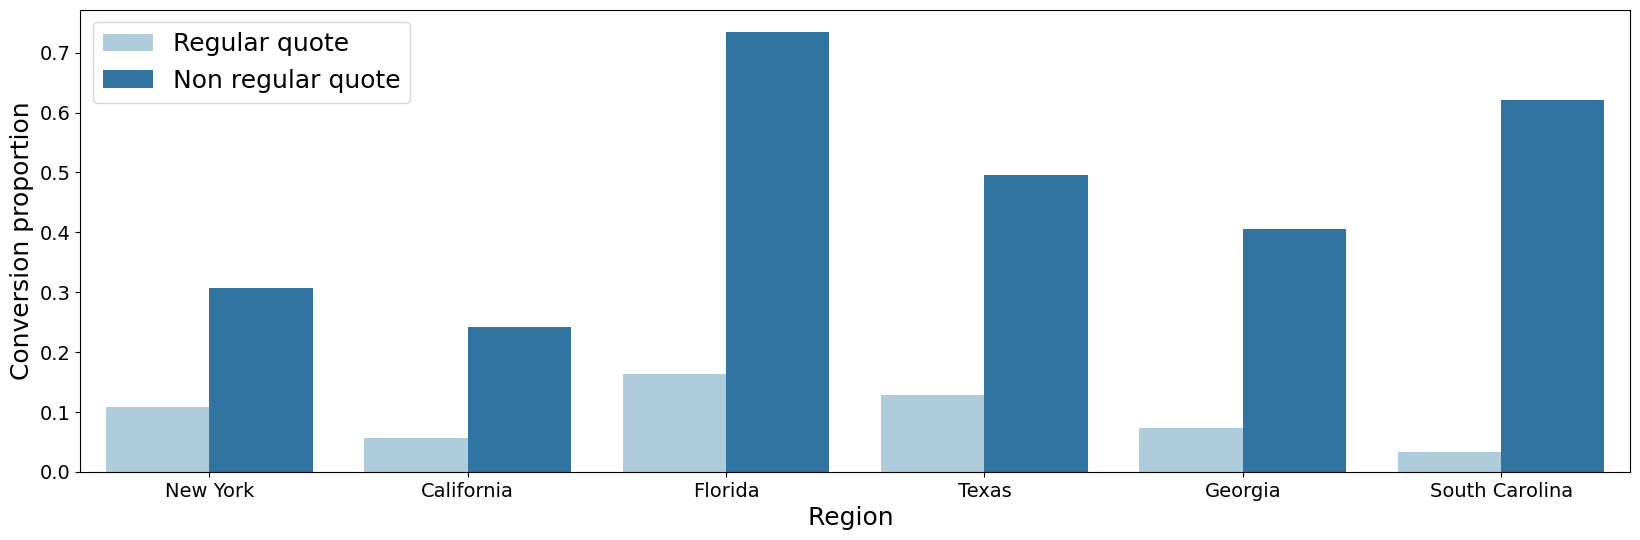

In [23]:
# success rate of quotes in qto vs non qto
import seaborn as sns
palette = sns.color_palette(palette='Paired')
sns.barplot(data=per_quote_markup[per_quote_markup[REGION_COLUMN].isin(TOP_10_REGIONS[:6])], x=REGION_COLUMN, y=QUOTE_STATUS, hue=QTO_COLUMN, errorbar=None, estimator="mean", palette=palette)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.xlabel("Region ", fontsize=18)
plt.ylabel("Conversion proportion", fontsize=18)
plt.show()

/var/folders/ds/1rp8l3k557s90rf79xcczzg00000gp/T/ipykernel_45359/18822205.py:4: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.barplot(data=per_quote_markup[per_quote_markup[REGION_COLUMN].isin(TOP_10_REGIONS[6:])], x=REGION_COLUMN, y=MARKUP_COLUMN, hue=QTO_COLUMN, errorbar=None, estimator="mean", palette=palette)


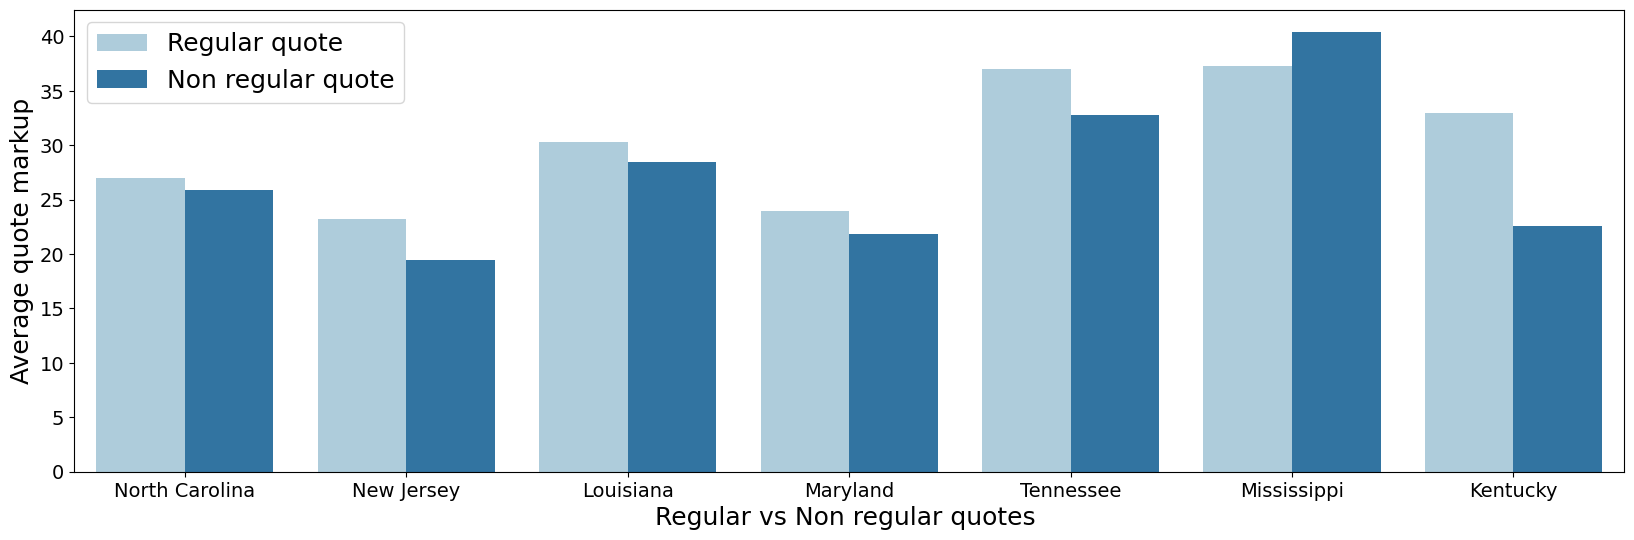

In [24]:
# success rate of quotes in qto vs non qto
import seaborn as sns
palette = sns.color_palette(palette='Paired')
sns.barplot(data=per_quote_markup[per_quote_markup[REGION_COLUMN].isin(TOP_10_REGIONS[6:])], x=REGION_COLUMN, y=MARKUP_COLUMN, hue=QTO_COLUMN, errorbar=None, estimator="mean", palette=palette)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.xlabel("Regular vs Non regular quotes ", fontsize=18)
plt.ylabel("Average quote markup", fontsize=18)
plt.show()

### success rate of quotes in request purpose

In [25]:
per_quote_markup[REQUEST_PURPOSE_COLUMN].value_counts()

Request Purpose
For Bid        5121
For Install    3972
Name: count, dtype: int64

/var/folders/ds/1rp8l3k557s90rf79xcczzg00000gp/T/ipykernel_45359/3897085750.py:4: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.barplot(data=per_quote_markup[per_quote_markup[REGION_COLUMN].isin(TOP_10_REGIONS[6:])], x=REGION_COLUMN, y=QUOTE_STATUS, hue=REQUEST_PURPOSE_COLUMN, errorbar=None, estimator="mean", palette=palette)


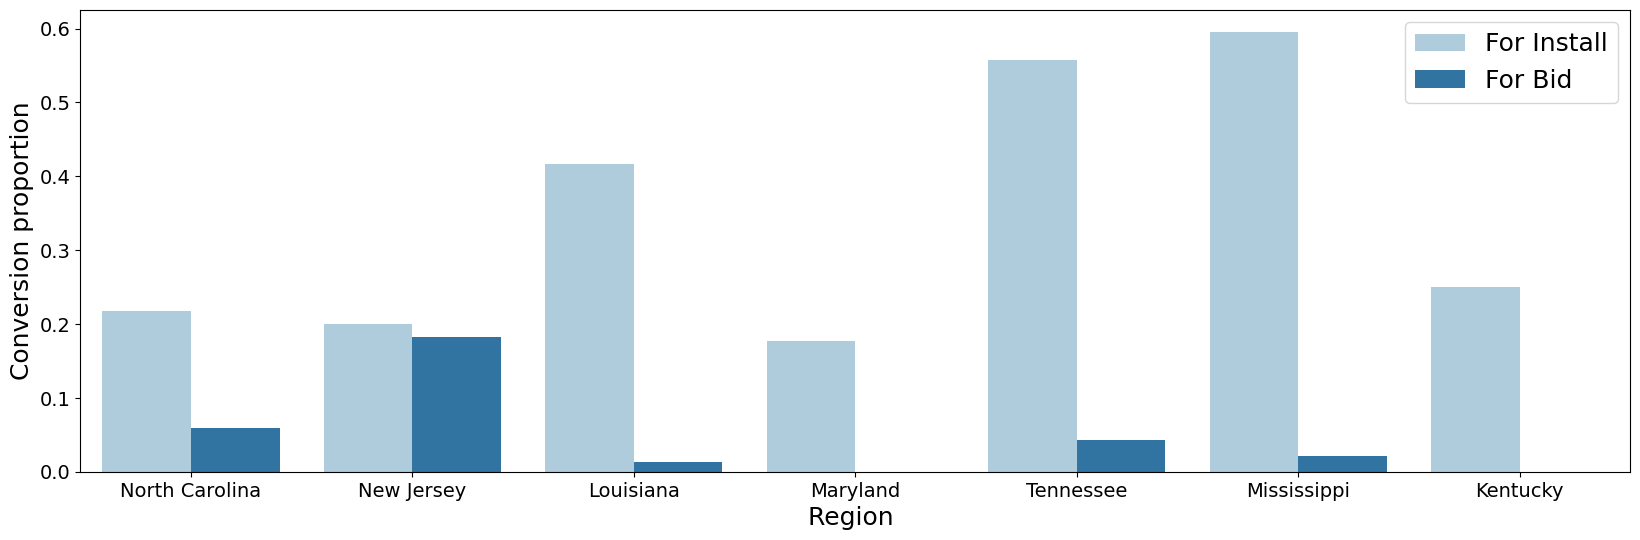

In [26]:
# success rate of quotes in bid vs install
import seaborn as sns
palette = sns.color_palette(palette='Paired')
sns.barplot(data=per_quote_markup[per_quote_markup[REGION_COLUMN].isin(TOP_10_REGIONS[6:])], x=REGION_COLUMN, y=QUOTE_STATUS, hue=REQUEST_PURPOSE_COLUMN, errorbar=None, estimator="mean", palette=palette)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.xlabel("Region ", fontsize=18)
plt.ylabel("Conversion proportion", fontsize=18)
plt.show()

/var/folders/ds/1rp8l3k557s90rf79xcczzg00000gp/T/ipykernel_45359/3335562534.py:4: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.barplot(data=per_quote_markup[per_quote_markup[REGION_COLUMN].isin(TOP_10_REGIONS[6:])], x=REGION_COLUMN, y=MARKUP_COLUMN, hue=REQUEST_PURPOSE_COLUMN, errorbar=None, estimator="mean", palette=palette)


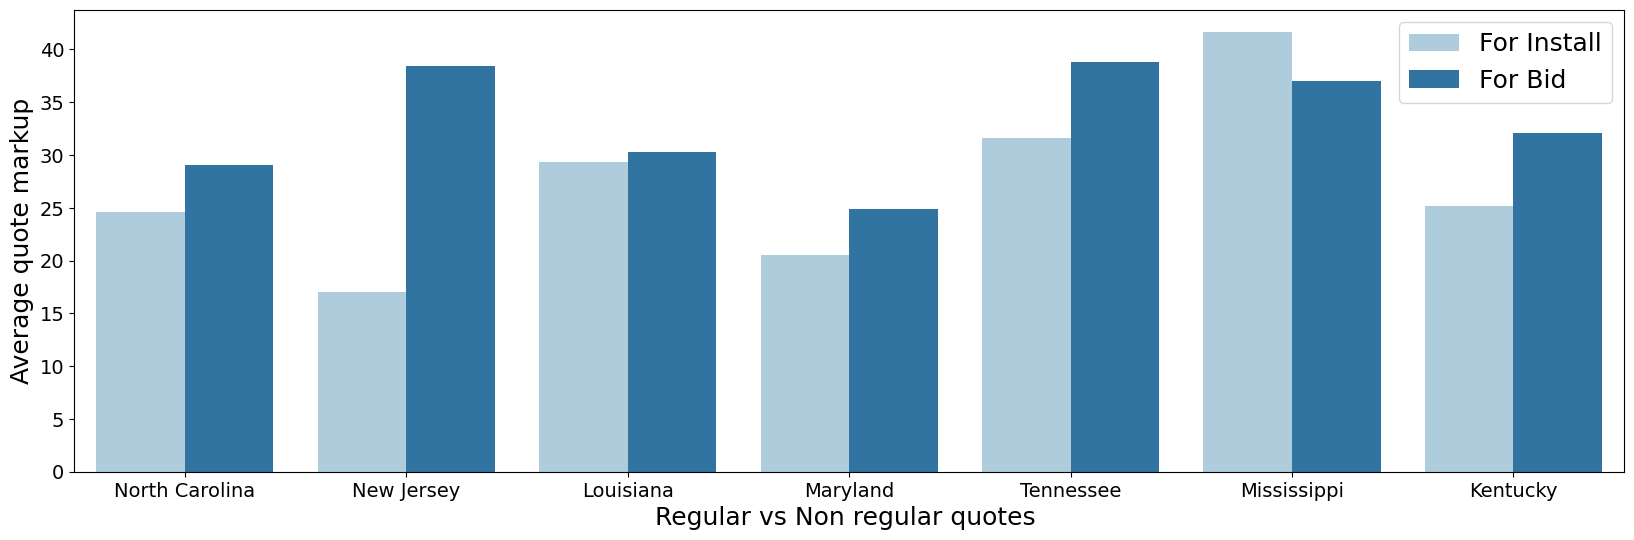

In [27]:
# success rate of quotes in qto vs non qto
import seaborn as sns
palette = sns.color_palette(palette='Paired')
sns.barplot(data=per_quote_markup[per_quote_markup[REGION_COLUMN].isin(TOP_10_REGIONS[6:])], x=REGION_COLUMN, y=MARKUP_COLUMN, hue=REQUEST_PURPOSE_COLUMN, errorbar=None, estimator="mean", palette=palette)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.xlabel("Regular vs Non regular quotes ", fontsize=18)
plt.ylabel("Average quote markup", fontsize=18)
plt.show()

# Build classifier

In [29]:
data[ORDER_ID_COLUMN].nunique()

9093

In [ ]:
# mask = (data[REQUEST_PURPOSE_COLUMN] =="For Bid") & (data[QTO_COLUMN]=="No")
# data =  data[~mask]

In [ ]:
SELECTED_COLUMNS = [
    CUSTOMER_COLUMN,
    ORDER_DATE,
    ORDER_ID_COLUMN,
    PRODUCT_ID_COLUMN,
    PLANT_CATEGORY_COLUMN,
    QUOTE_STATUS,
    REGION_COLUMN,
    SELLER_TOTAL,
    MARKUP_COLUMN,
    TOTAL_ITEMS_COLUMN,
    PLANT_NAME_COLUMN,
    REQUEST_PURPOSE_COLUMN,
    QTO_COLUMN,
    ]

In [ ]:
data = data[SELECTED_COLUMNS]

In [ ]:
data.head()

In [ ]:
original_data = data.copy()

In [ ]:
# data[PLANT_NAME_COLUMN].nunique()
# data[PLANT_NAME_COLUMN].value_counts().quantile(0.95)
data[PLANT_CATEGORY_COLUMN].value_counts()
# data[PLANT_CATEGORY_COLUMN].nunique()


In [ ]:
PLANT_CATEGORIES = data[PLANT_CATEGORY_COLUMN].unique()
PLANT_CATEGORIES

In [ ]:
PLANT_CATEGORY_INPUT = "Shrubs"

In [ ]:
# train_data = data[data[PLANT_CATEGORY_COLUMN] == PLANT_CATEGORY_INPUT]
train_data = data

In [ ]:
data[QUOTE_STATUS].value_counts()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
    

def _prepare_category_data(train_data):
    train_data = train_data[
    [
        QUOTE_STATUS,
        SELLER_TOTAL,
        MARKUP_COLUMN,
        TOTAL_ITEMS_COLUMN,
        REGION_COLUMN,
        PLANT_CATEGORY_COLUMN,
        PLANT_NAME_COLUMN,
        REQUEST_PURPOSE_COLUMN,
        QTO_COLUMN,
    ]
    ]
    train_data = train_data[train_data[REGION_COLUMN].isin(TOP_10_REGIONS)]
    print(train_data[QUOTE_STATUS].value_counts())

    accepted_quotes = train_data[train_data[QUOTE_STATUS] == 1]
    refused_quotes = train_data[train_data[QUOTE_STATUS] == 0].sample(int(len(accepted_quotes)*2))
    train_data = pd.concat([accepted_quotes, refused_quotes], ignore_index=True).sample(frac=1.0)
    return train_data


def train_model(train_data):
    train_data = _prepare_category_data(train_data)
    # Features and target
    X_train, X_test, y_train, y_test, pipeline = _fit_model(train_data)
    # Best threshold
    best_threshold = _retrieve_best_threshold(pipeline, X_test, y_test)
    pipeline.best_threshold = best_threshold
    # Display confusion matrix
    _display_cm(pipeline, X_test, y_test, best_threshold)

    return pipeline, X_train, X_test, y_train, y_test

def _fit_model(train_data):
    X = train_data.drop(QUOTE_STATUS, axis=1)
    y = train_data[QUOTE_STATUS]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

    # Column Transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), [TOTAL_ITEMS_COLUMN, SELLER_TOTAL, MARKUP_COLUMN]),
            ('cat_2', OrdinalEncoder(
                handle_unknown="use_encoded_value", 
                unknown_value=-1
                ),
                [
                    PLANT_CATEGORY_COLUMN, 
                    REGION_COLUMN,
                    REQUEST_PURPOSE_COLUMN,
                    QTO_COLUMN,
                    
                    ])
        ],
        # remainder="passthrough",
        remainder="drop",
    ).set_output(transform="pandas")

    # Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        # ('classifier', GradientBoostingClassifier(random_state=42))
        ('classifier', HistGradientBoostingClassifier(
            random_state=42, 
            categorical_features=[
                                f"cat_2__{PLANT_CATEGORY_COLUMN}", 
                                f"cat_2__{REGION_COLUMN}", 
                                f"cat_2__{REQUEST_PURPOSE_COLUMN}", 
                                f"cat_2__{QTO_COLUMN}", 
                                  ]
                                  )
                                  ),
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    return X_train,X_test,y_train,y_test,pipeline


def _retrieve_best_threshold(pipeline, X_test, y_test):
    
    display = PrecisionRecallDisplay.from_estimator(
        pipeline, X_test, y_test, name="Classifier", plot_chance_level=False
    )
    _ = display.ax_.set_title("Precision-Recall curve")

    # Predict probabilities on the test set
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Get precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    f1_score = 2 * (precision * recall) / (precision + recall)
    best_f1_score_index = f1_score.argmax()
    best_threshold = thresholds[best_f1_score_index]
    print(best_threshold)
    return best_threshold


def _display_cm(pipeline, X_test, y_test, best_threshold):
    # Predictions 
    y_proba = pipeline.predict_proba(X_test) 
    y_pred = np.where(y_proba[:, 1] > best_threshold, 1, 0) 
    # Confusion Matrix s
    cm = confusion_matrix(y_test, y_pred) 
    # Display Confusion Matrix 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["refused_quotes", "accepted quotes"]) 
    disp.plot(cmap=plt.cm.Blues) 
    plt.show()


In [ ]:
pipeline, X_train, X_test, y_train, y_test = train_model(train_data)

# Brier score
## Global score

In [ ]:
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score

# Predict probabilities on the test set
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Compute Brier score
brier_score = brier_score_loss(y_test, y_prob)
entropy_score = log_loss(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

print(f"Brier score: {brier_score}")
print(f"Entropy score: {entropy_score}")
print(f"AUC score: {auc_score}")

In [ ]:
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score

# Predict probabilities on the test set
m= (X_test[QTO_COLUMN] == "No") & (X_test[REQUEST_PURPOSE_COLUMN] =="For Bid")
_X_test = X_test[m]
_y_test = y_test[_X_test.index]
y_prob = pipeline.predict_proba(_X_test)[:, 1]

# Compute Brier score
brier_score = brier_score_loss(_y_test, y_prob)
entropy_score = log_loss(_y_test, y_prob)
auc_score = roc_auc_score(_y_test, y_prob)

print(f"Brier score: {brier_score}")
print(f"Entropy score: {entropy_score}")
print(f"AUC score: {auc_score}")

In [ ]:
m.sum(),len(X_test)

## Brier score for 3 most popular categories

In [ ]:
for category in [
    "Trees",
    "Shrubs",
    "Perennials",
    "Conifers",
    ]:
    selected_items = X_test[X_test[PLANT_CATEGORY_COLUMN] == category]
    selected_items_groundtruth = y_test.loc[selected_items.index]
    selected_items_proba = pipeline.predict_proba(selected_items)[:,1]
    score = brier_score_loss(selected_items_groundtruth, selected_items_proba)
    print(f"Brier score for category {category}: {score}")



# Sensitivity to markup

In [ ]:
X_train.head()

In [ ]:
preprocessor = pipeline.steps[0][1]
processed_X_train = preprocessor.transform(X_train)
processed_X_train.head()

In [ ]:
processed_X_train.dtypes

In [ ]:
pipeline.steps

In [ ]:
# model = pipeline.steps[1][1]
# df = processed_X_train.sample(2500)
# processed_X_test = preprocessor.transform(X_test).sample(2000)
# explainer = shap.explainers.Permutation(model.predict_proba, df)
# shap_values = explainer(processed_X_test)
# shap_values = shap_values[..., 1]

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
model.predict_proba(processed_X_test.iloc[:1])

# Partial dependency plot

In [ ]:
stop

In [ ]:
X_train.head()

In [ ]:
mask = (data[REQUEST_PURPOSE_COLUMN] =="For Bid") & (X_train[QTO_COLUMN]=="No")
# X_train =  X_train[mask]

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
features = [1]
PartialDependenceDisplay.from_estimator(pipeline, X_test, features,
    kind='average')
plt.title("Partial dependence plot",  fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Markup value", fontsize=18)
plt.ylabel("Partial dependence", fontsize=18)

# Calibration Curve

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from matplotlib.ticker import PercentFormatter

fig = plt.figure(figsize=(10, 10))

# Create the first subplot for the calibration curve
ax_calibration_curve = fig.add_subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot

display = CalibrationDisplay.from_estimator(
    pipeline,
    X_train,
    y_train.loc[X_train.index],
    n_bins=10,
    name="model",
    ax=ax_calibration_curve,
    strategy="uniform"
)
# Set the title of the calibration curve subplot
ax_calibration_curve.set_title("Calibration Curve", fontsize=20)

# # Set the font size for x and y ticks
ax_calibration_curve.set_xticklabels(ax_calibration_curve.get_xticks().round(1), fontsize=14)
ax_calibration_curve.set_yticklabels(ax_calibration_curve.get_yticks().round(1), fontsize=14)

# # Set the legend font size (assuming the legend already exists)
ax_calibration_curve.legend(fontsize=18)

# # Set the x and y labels with font size
ax_calibration_curve.set_xlabel("Mean predicted probability", fontsize=18)
ax_calibration_curve.set_ylabel("Fraction of positives", fontsize=18)


# Create the second subplot for the histogram
ax_hist = fig.add_subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot

ax_hist.hist(
    display.y_prob,
    range=(0, 1),
    bins=10,
    label="model",
    weights=np.ones(len(display.y_prob)) / len(display.y_prob)
)
ax_hist.set_title("Histogram of Predicted Probabilities", fontsize=20)
ax_hist.set_xlabel("Predicted Probability", fontsize=18)
ax_hist.set_ylabel("Proportion", fontsize=18)
ax_hist.tick_params(axis='both', which='major', labelsize=14)
ax_hist.yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.show()


In [ ]:
len(X_train)